In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import clip
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cat_dog1.csv")

# Split the dataset into training and testing (20% is Tesing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
#Set the device accordingly and makes the process and calculation s faster and load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)


In [17]:

# Function to extract CLIP embeddings for a given DataFrame
def clipEmbeddings(data_frame):
    embeddings = []
    labels = []
    for index, row in data_frame.iterrows():
        # Get the image path and label from the DataFrame
        image_path = os.path.join("cat_dog1", row['image'])
        label = row['labels']
        
        # Transform and move the image to the specified device
        image = transform(Image.open(image_path)).unsqueeze(0).to(device)
        
        # Extract CLIP embedding for the image
        embedding = model.encode_image(image)

        # Append the embedding and label to the lists
        embeddings.append(embedding.detach().numpy())
        labels.append(label)

    return np.concatenate(embeddings), np.array(labels)


# Extract CLIP embeddings for the training and testing sets
train_embeddings, train_labels = clipEmbeddings(train_df)
test_embeddings, test_labels = clipEmbeddings(test_df)

# Combine the embeddings and labels into feature arrays
train_features = np.column_stack((train_embeddings, train_labels))
test_features = np.column_stack((test_embeddings, test_labels))

# Calculate the mean vectors (m1 and m2) for each class
class_means = [np.mean(train_features[train_features[:, -1] == label][:, :-1], axis=0) for label in np.unique(train_labels)]

# Calculate the within-class scatter matrix (S)
within_class_scatter = sum([np.cov(train_features[train_features[:, -1] == label][:, :-1], rowvar=False) for label in np.unique(train_labels)])

# Fisher's Linear Discriminant Analysis

# Set the regularization parameter (C) - analogous to the equation
C = 0.1
# C = 0.5
# C = 1.0

# Calculate the inverted within-class scatter matrix (S^-1) with regularization
inverted_within_class_scatter = np.linalg.inv(within_class_scatter + C * np.eye(within_class_scatter.shape[0]))

# Calculate Fisher's Linear Discriminant Analysis weight (w)
w = np.dot(inverted_within_class_scatter, (class_means[1] - class_means[0]))

# Project the training and testing data onto the discriminant axis
train_predictions = np.dot(train_embeddings, w)
test_predictions = np.dot(test_embeddings, w)


train_predictions_labels = np.where(train_predictions > 0, 1, 0)
test_predictions_labels = np.where(test_predictions > 0, 1, 0)





In [23]:
# Calculate additional metrics

train_accuracy = accuracy_score(train_labels, train_predictions_labels)
precision_train = precision_score(train_labels, train_predictions_labels)
recall_train = recall_score(train_labels, train_predictions_labels)
f1_train = f1_score(train_labels, train_predictions_labels)


test_accuracy = accuracy_score(test_labels, test_predictions_labels)
precision_test = precision_score(test_labels, test_predictions_labels)
recall_test = recall_score(test_labels, test_predictions_labels)
f1_test = f1_score(test_labels, test_predictions_labels)


# Confusion matrix
conf_matrix_train = confusion_matrix(train_labels, train_predictions_labels)
conf_matrix_test = confusion_matrix(test_labels, test_predictions_labels)



print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision:{precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Training F1 Score: {f1_train}")

print("-----------------------------")

print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {precision_test}")
print(f"Testing Recall: {recall_test}")
print(f"Testing F1 Score: {f1_test}")







Training Accuracy: 0.99875
Training Precision:1.0
Training Recall: 0.9975031210986267
Training F1 Score: 0.99875
-----------------------------
Testing Accuracy: 1.0
Testing Precision: 1.0
Testing Recall: 1.0
Testing F1 Score: 1.0


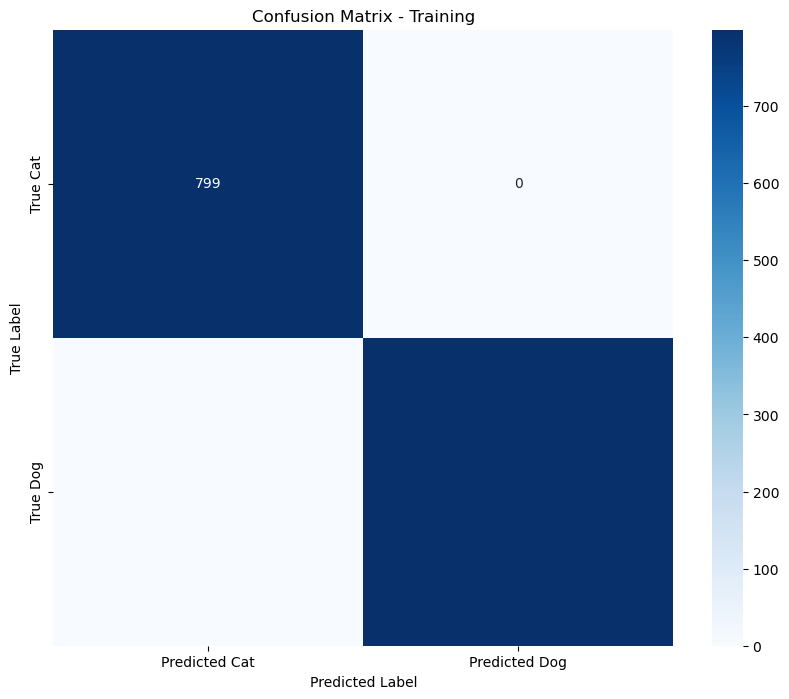

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Cat', 'Predicted Dog'], yticklabels=['True Cat', 'True Dog'])
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
print("Trainning Confusion Matrix")
print(conf_matrix_train)
print("-----------------")

print("Trainning Confusion Matrix")
print(conf_matrix_test)


Trainning Confusion Matrix
[[799   0]
 [  2 799]]
-----------------
Trainning Confusion Matrix
[[201   0]
 [  0 199]]


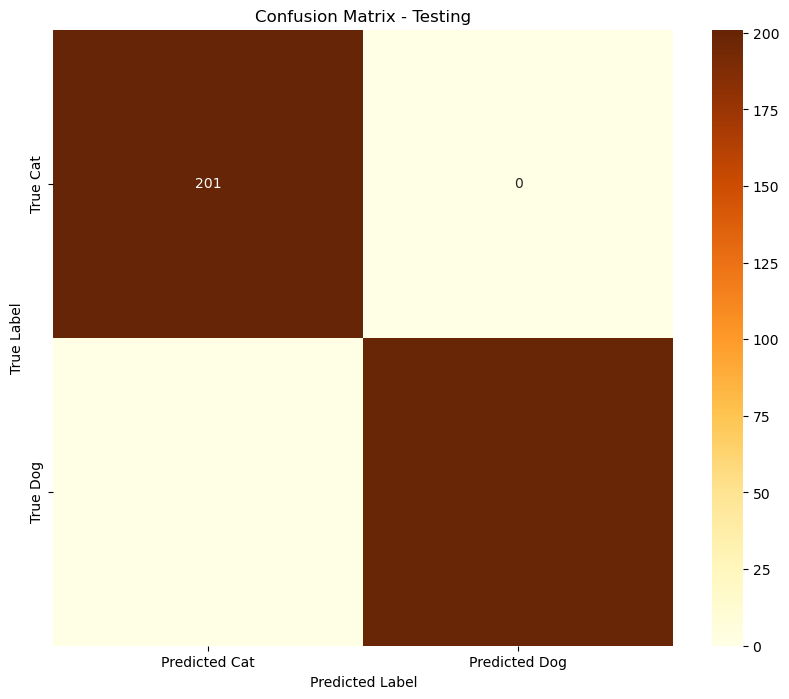

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with dark orange color
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['Predicted Cat', 'Predicted Dog'], yticklabels=['True Cat', 'True Dog'])
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**This part here i made to check this part i get an image that doesnt exist in the dataset that is a completly new image and let the model predicts the new image and classify it.**

In [28]:
new_image_path = "image.jpeg"  # Provide the path to your new image
new_image = transform(Image.open(new_image_path)).unsqueeze(0).to(device)
new_image_embedding = model.encode_image(new_image)

# Project the new image embedding using the weight vector w
new_image_prediction = np.dot(new_image_embedding.detach().numpy(), w)

# Apply the threshold (0 in this case) to make the prediction
new_image_prediction_label = 1 if new_image_prediction > 0 else 0

# Print the prediction
print(f"Prediction for {new_image_path}: {'Dog' if new_image_prediction_label == 1 else 'Cat'}")

Prediction for image.jpeg: Cat
